In [1]:
import os
import sys
import pandas as pd
import numpy as np

import seaborn as sns
sns.set(rc={'figure.figsize':(20, 12)})
sns.set_theme(style="whitegrid")

pd.set_option("display.max_rows", None, "display.max_columns", None)

import warnings
warnings.filterwarnings("ignore")

In [2]:
import dataset
import analysis

In [3]:
k_data_path = '../generate_data/data/thres_inf/'
k_train_dates = [
    #'2020-06-30',
    '2020-09-30',
    '2020-12-31',
    '2021-03-31',
    '2021-06-30',
    #'2021-09-30',
]

k_test_dates = ['2021-09-30']

k_cutpoints = [-0.3, -0.1, 0.1, 0.3]
k_stocks_only = '.SH'

In [4]:
args = dataset.Args(data_path   = k_data_path,
                    train_dates = k_train_dates,
                    test_dates  = k_test_dates,
                    classifier_cut_points = k_cutpoints,
                    stocks_only = k_stocks_only,
                    )
ds = dataset.DataSet.create(args)

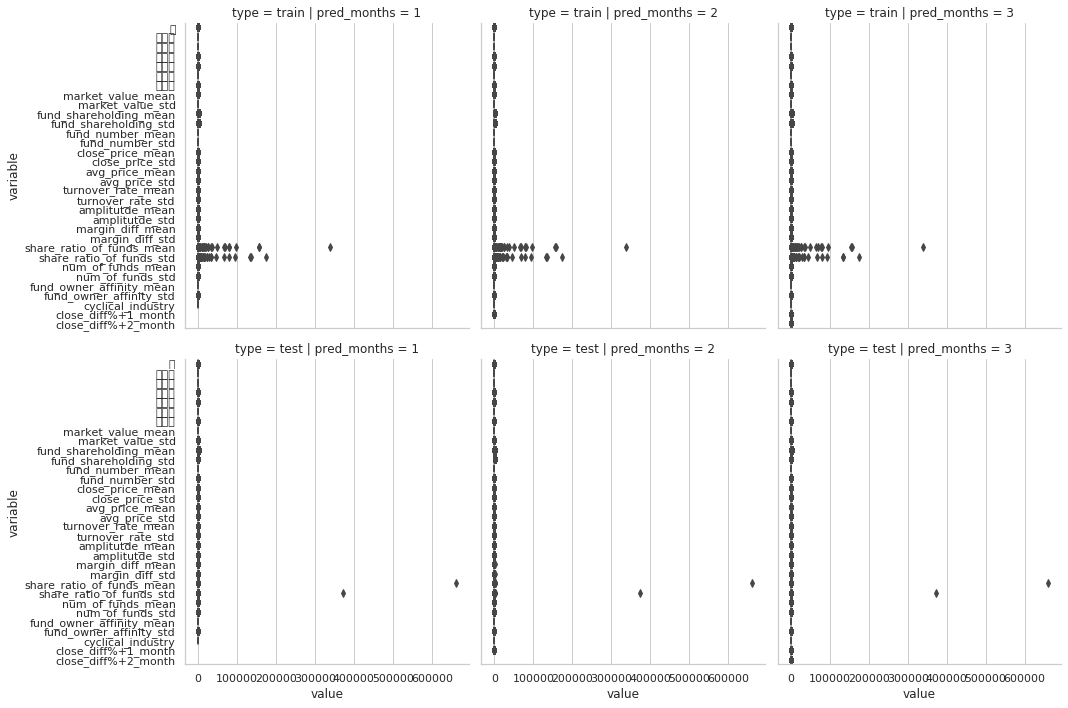

In [5]:
data = []
for months, d in ds.items():
    x_train = d.x_train.melt()
    x_train['type']         = 'train'
    x_train['pred_months']  = months
    data.append(x_train)

    x_test = d.x_test.melt()
    x_test['type']         = 'test'
    x_test['pred_months']  = months
    data.append(x_test)
data = pd.concat(data)

g = sns.catplot(kind    = 'box',
                x       = 'value',
                y       = 'variable',
                col     = 'pred_months',
                row     = 'type',
                data    = data)
g


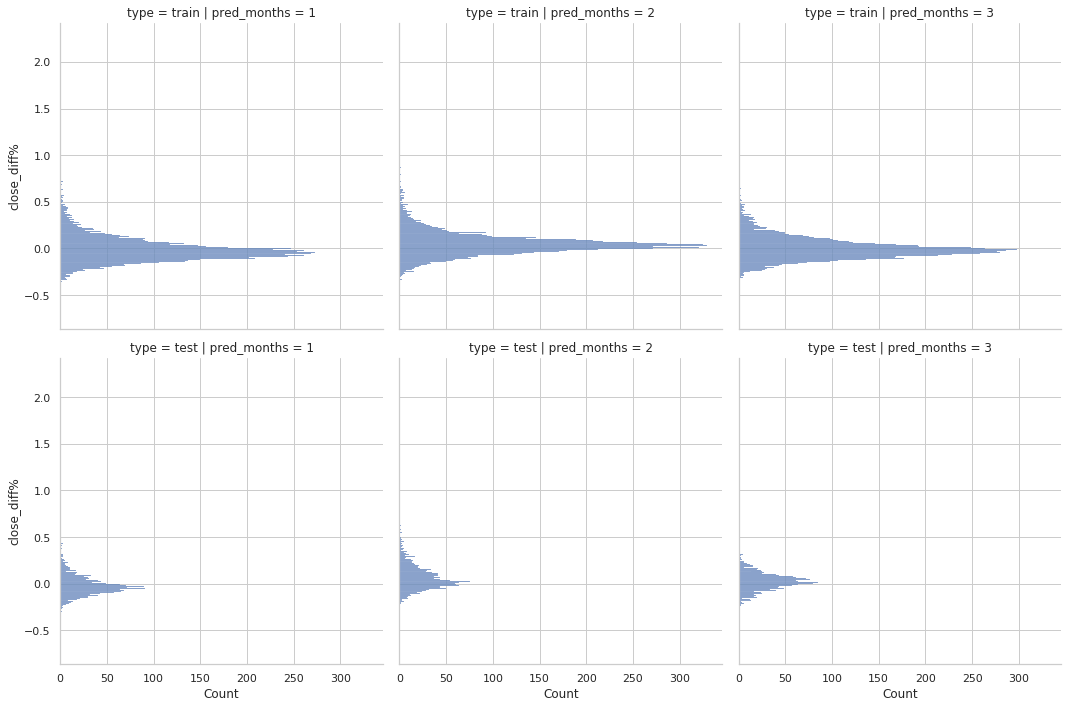

In [6]:
data = []
for months, d in ds.items():
    y_train = pd.DataFrame()
    y_train['close_diff%']  = d.y_train
    y_train['type']         = 'train'
    y_train['pred_months']  = months
    data.append(y_train)

    y_test = pd.DataFrame()
    y_test['close_diff%']  = d.y_test
    y_test['type']         = 'test'
    y_test['pred_months']  = months
    data.append(y_test)
data = pd.concat(data, ignore_index=True)

g = sns.displot(data = data,
                y    = 'close_diff%',
                col  = 'pred_months',
                row  = 'type')
g

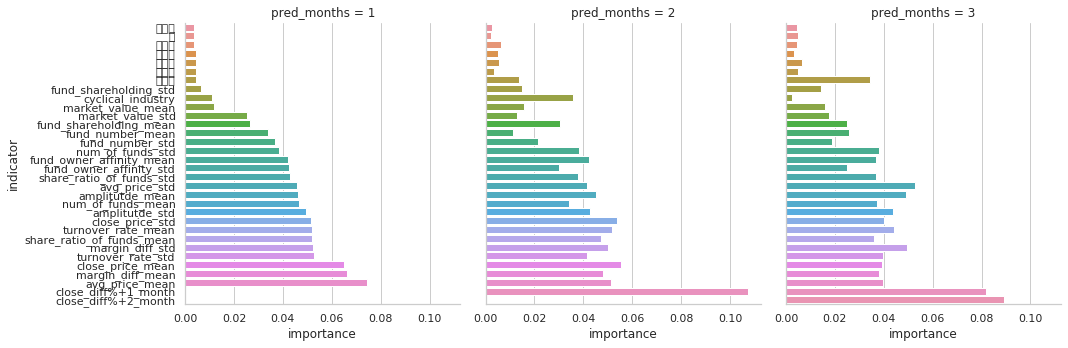

In [7]:
data = []
for months, d in ds.items():
    imp = analysis.compute_feature_importance(d)
    imp['pred_months'] = months
    data.append(imp)

data = pd.concat(data)

g = sns.catplot(kind    = 'bar',
                x       = 'importance',
                y       = 'indicator',
                col     = 'pred_months',
                data    = data)
g